# Predição de CRA 

## Author: Caio Batista Oliveira

### Lendo os dados e sumarizando

Para começar a leitura dos dados foi feita e logo como já se possuia o conhecimento das dimensões do csv, a feature <b>Matrícula</b> não teria nenhuma utilidade, por ser apenas uma caracteristica categórica e não ter influência nenhuma nas notas dos alunos, logo foi removida em todas as instâncias desse laboratório. E a primeira coisa a se pensar quando lemos os dados é a falta de informação, por isso a verificação de NA's foi feita e constatada que não havia valores faltantes, como pode-se ver abaixo.

In [345]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from math import sqrt




%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [346]:
all_data = pd.read_csv("treino.csv")
all_data.head()
del all_data["matricula"]
print("Number of NaN: {0}".format(all_data.isnull().sum().sum()))



Number of NaN: 0


<p></p>

Aqui fazemos a sumarização dos dados, mostrando as dimensões deles e separando a primeira parte entre treino e teste. Essa divisão foi feita em que o treino compreende todos os dados exceto os 20 últimos que são destinados ao teste.

In [347]:
all_data.tail()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
83,8.0,10.0,5.1,7.0,5.5,7.3,5.2,8.3,7.4,5.8,8.9,6.986207,7.1
84,7.1,7.8,5.0,8.2,5.0,8.2,7.0,7.8,8.2,7.0,8.9,7.102247,8.0
85,5.0,7.2,7.8,7.4,8.1,5.3,7.0,6.7,5.9,7.1,7.5,7.282022,5.0
86,9.2,8.0,8.9,9.8,9.8,8.1,8.0,9.3,9.8,8.2,9.1,8.924706,9.5
87,7.0,8.6,7.4,8.3,5.9,5.0,5.3,7.6,7.2,8.3,9.0,7.300000,6.1


In [348]:
train = all_data[:-20]
train.head()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
0,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
1,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
2,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
3,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
4,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


In [349]:
test = all_data[-20:]
test.tail()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
83,8.0,10.0,5.1,7.0,5.5,7.3,5.2,8.3,7.4,5.8,8.9,6.986207,7.1
84,7.1,7.8,5.0,8.2,5.0,8.2,7.0,7.8,8.2,7.0,8.9,7.102247,8.0
85,5.0,7.2,7.8,7.4,8.1,5.3,7.0,6.7,5.9,7.1,7.5,7.282022,5.0
86,9.2,8.0,8.9,9.8,9.8,8.1,8.0,9.3,9.8,8.2,9.1,8.924706,9.5
87,7.0,8.6,7.4,8.3,5.9,5.0,5.3,7.6,7.2,8.3,9.0,7.300000,6.1


<p></p>

Uma boa maneira de ver como os dados se comportam e principalmente onde se concentram é o histograma. Para isso aqui temos um plot para cada uma das dimensões das disciplinas que compõem esse csv. O que já chama a atenção é que nas disciplinas que envolvem matemática os alunos tem, em geral, um desempenho <b>menor</b> que no restante das disciplinas.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa73e19a828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa73dd4b7f0>]], dtype=object)

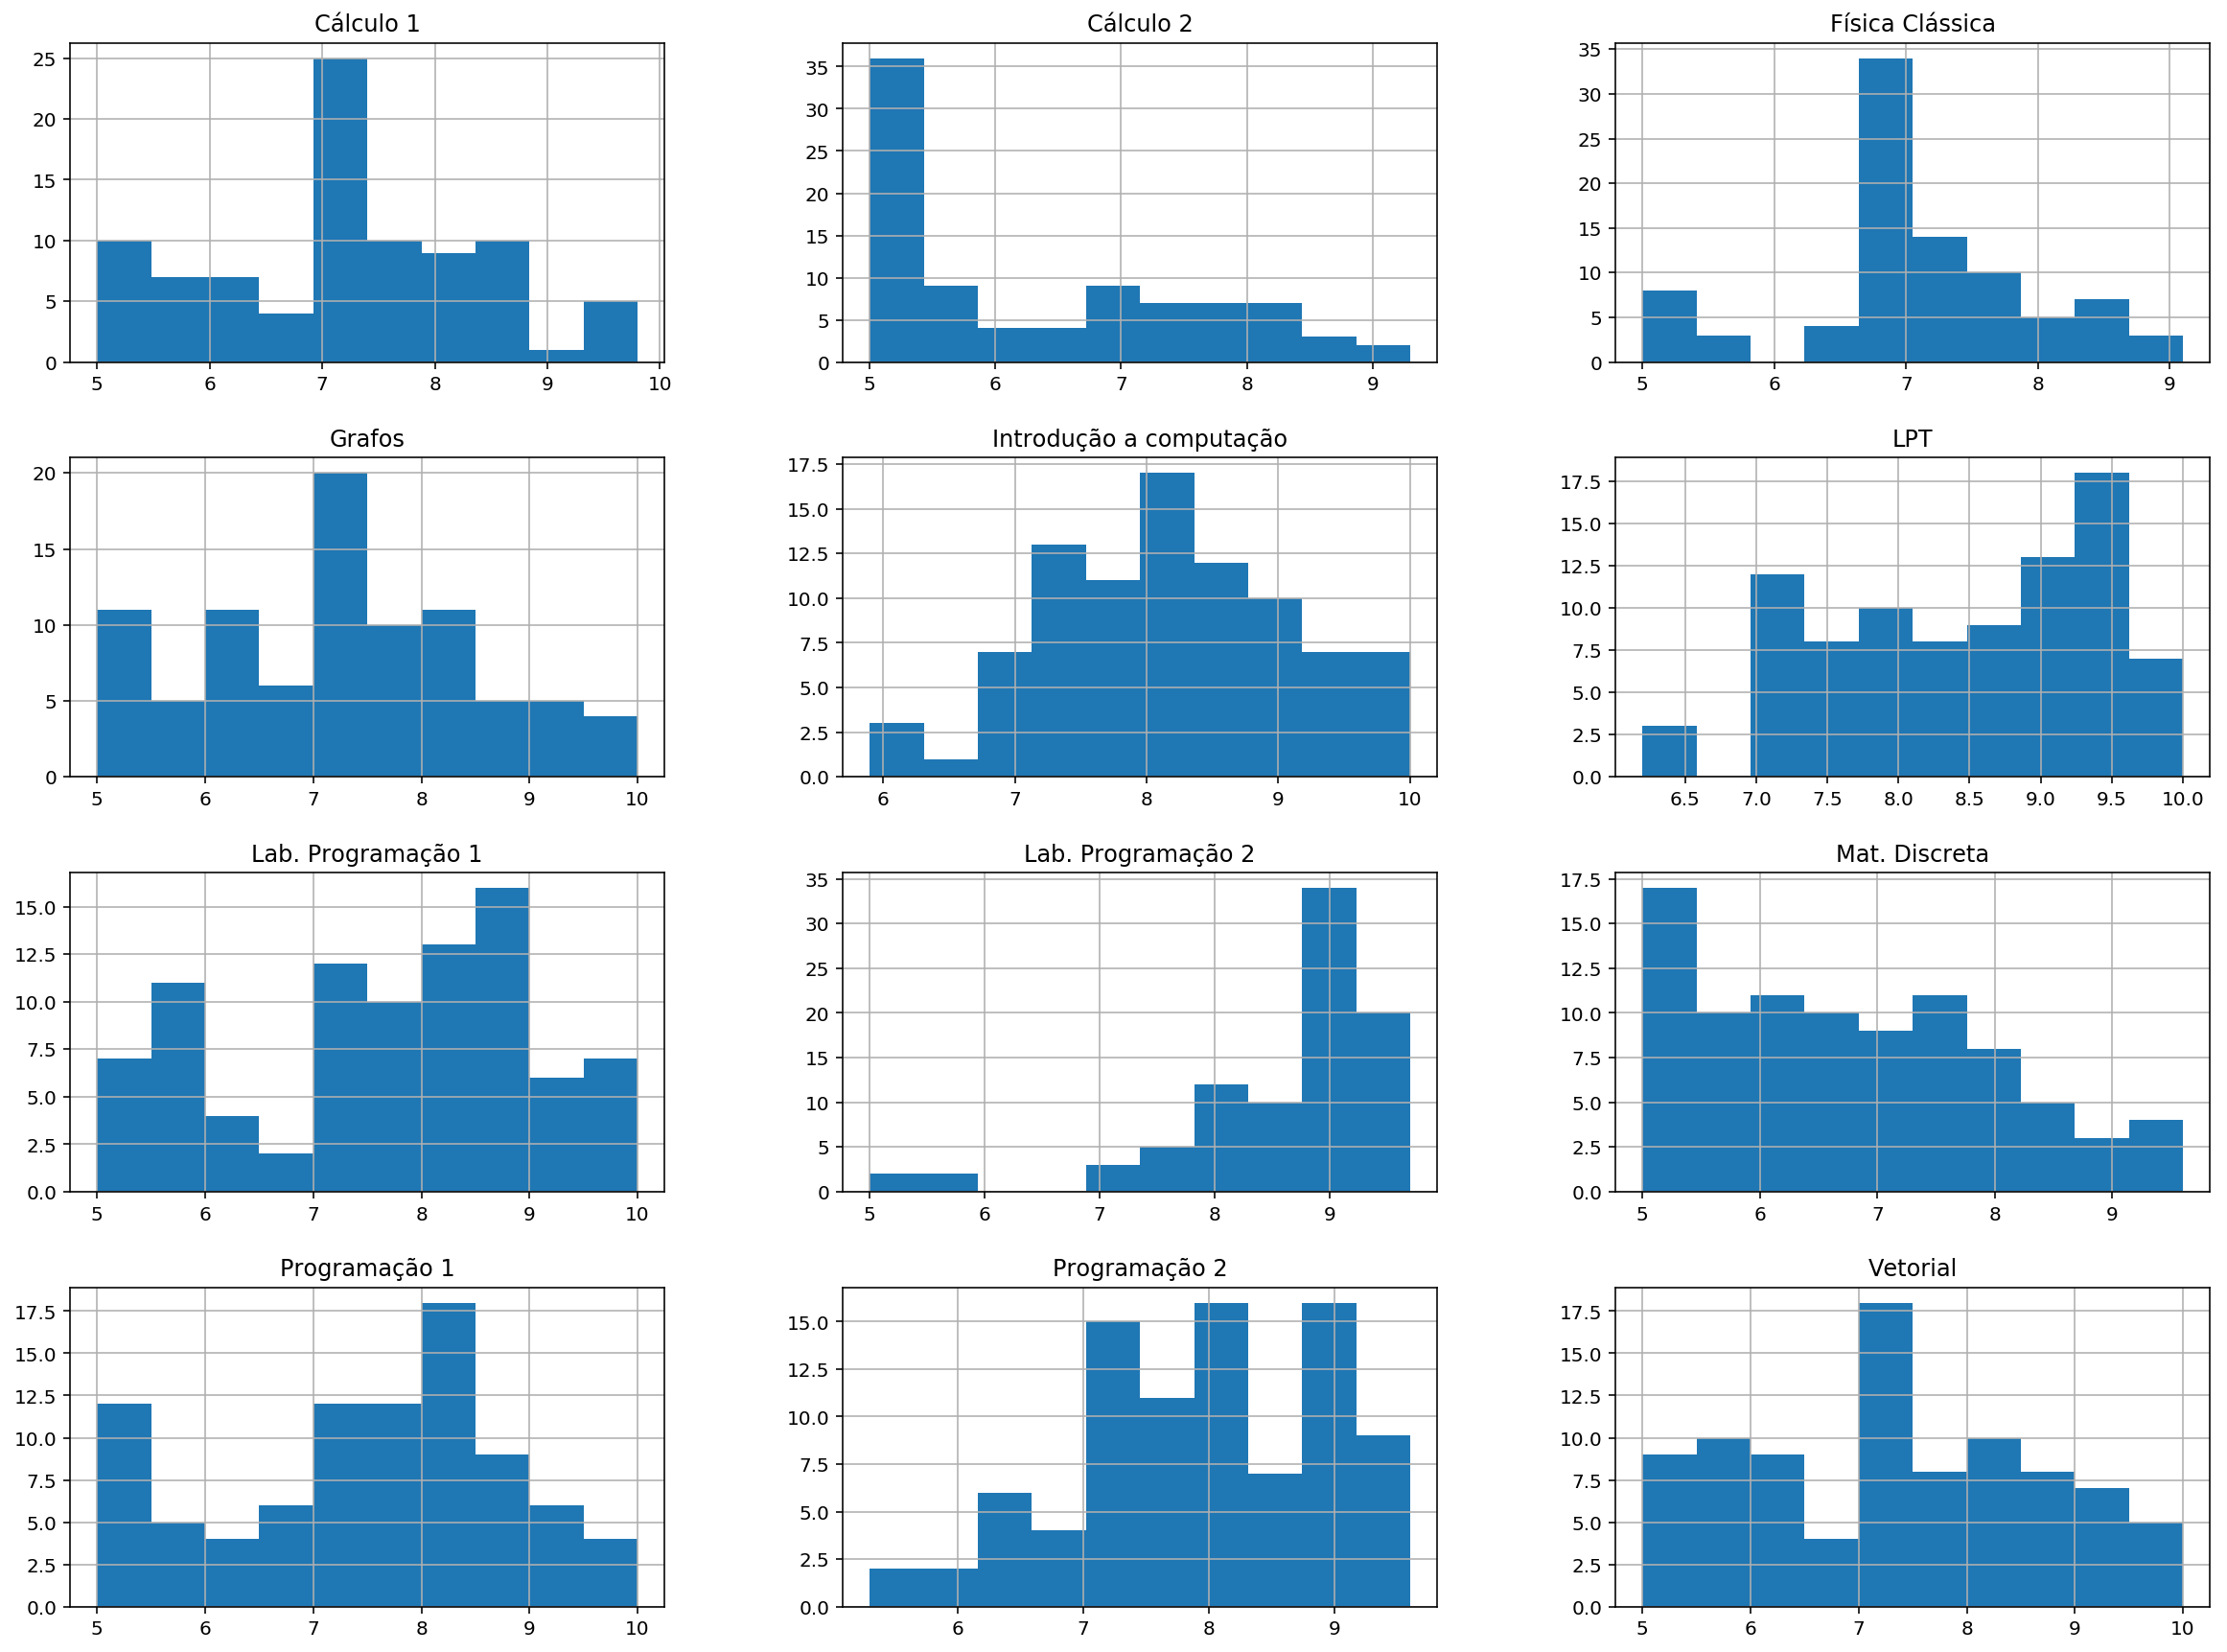

In [350]:
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)
grades = pd.DataFrame\
 ({"Vetorial":all_data["Vetorial"], "LPT":all_data["LPT"],"Programação 1":all_data["P1"], \
   "Lab. Programação 1":all_data["LP1"], "Cálculo 1":all_data["Cálculo1"], "Cálculo 2":all_data["Cálculo2"],\
   "Introdução a computação": all_data["IC"], "Mat. Discreta": all_data["Discreta"], "Grafos": all_data["Grafos"], \
   "Programação 2":all_data["P2"], "Lab. Programação 2":all_data["LP2"], "Física Clássica":all_data["Fís.Clássica"]\
  })
grades.hist()

<p></p>

Fazendo o mesmo histograma somente para a dimensão <b>CRA</b> podemos perceber que existe a concentração perto de 7 das notas. O que se parece com o histograma da disciplina <b>Vetorial</b>, que pode ter uma influência grande na formação dessa dimensão em questão. Comprovaremos com os modelos. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa73e1ab0f0>]], dtype=object)

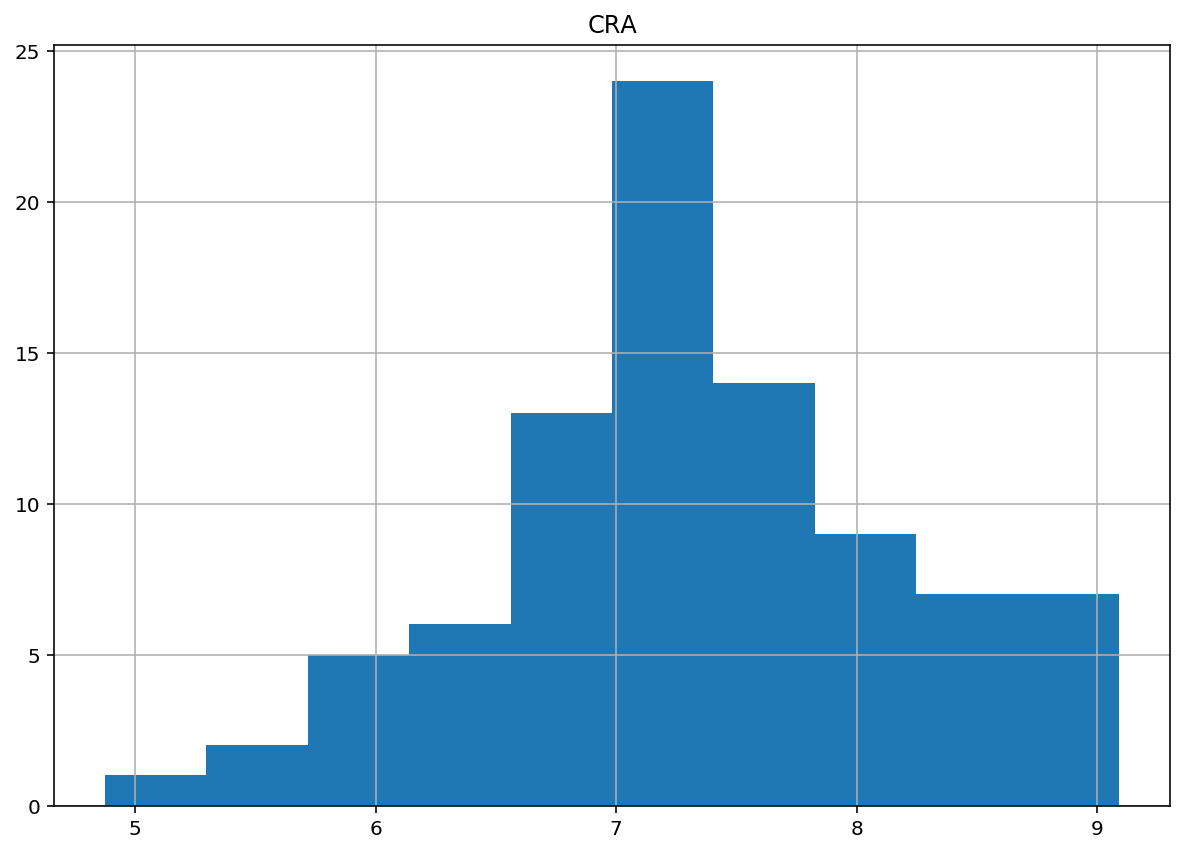

In [351]:
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
cra_plot = pd.DataFrame({"CRA":all_data["cra"]})
cra_plot.hist()

# ============================================================

## Modelos

### Tratamento antes da construção

Nessa sessão é feito o tratamento inicial dos dados separando os dados em treino e teste e criando as variáveis necessárias para criar os modelos, de forma básica, sem qualquer alteração nos parâmetros, apenas o mínimo necessário. 

In [352]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [353]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

del X_train["cra"]
del X_test["cra"]

y = train.cra
y_test = test.cra

# ============================================================

## RMSE

Duas funções úteis para verificarmos a melhoria dos modelos após mudar os parâmetros nas contruções.

In [354]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


# ============================================================

## Ridge

Para o modelo Ridge com o <b>alpha = 0</b> vemos que o <b>RMSE = 0.592</b> aproximadamente, e que as variáveis com mais peso na predição do <b>CRA</b> são <b>P2</b> e <b>Discreta</b>.   

In [355]:
model_ridge = Ridge(alpha = 0).fit(X_train,y)
pred = model_ridge.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))

RMSE: 0.5918653213911893


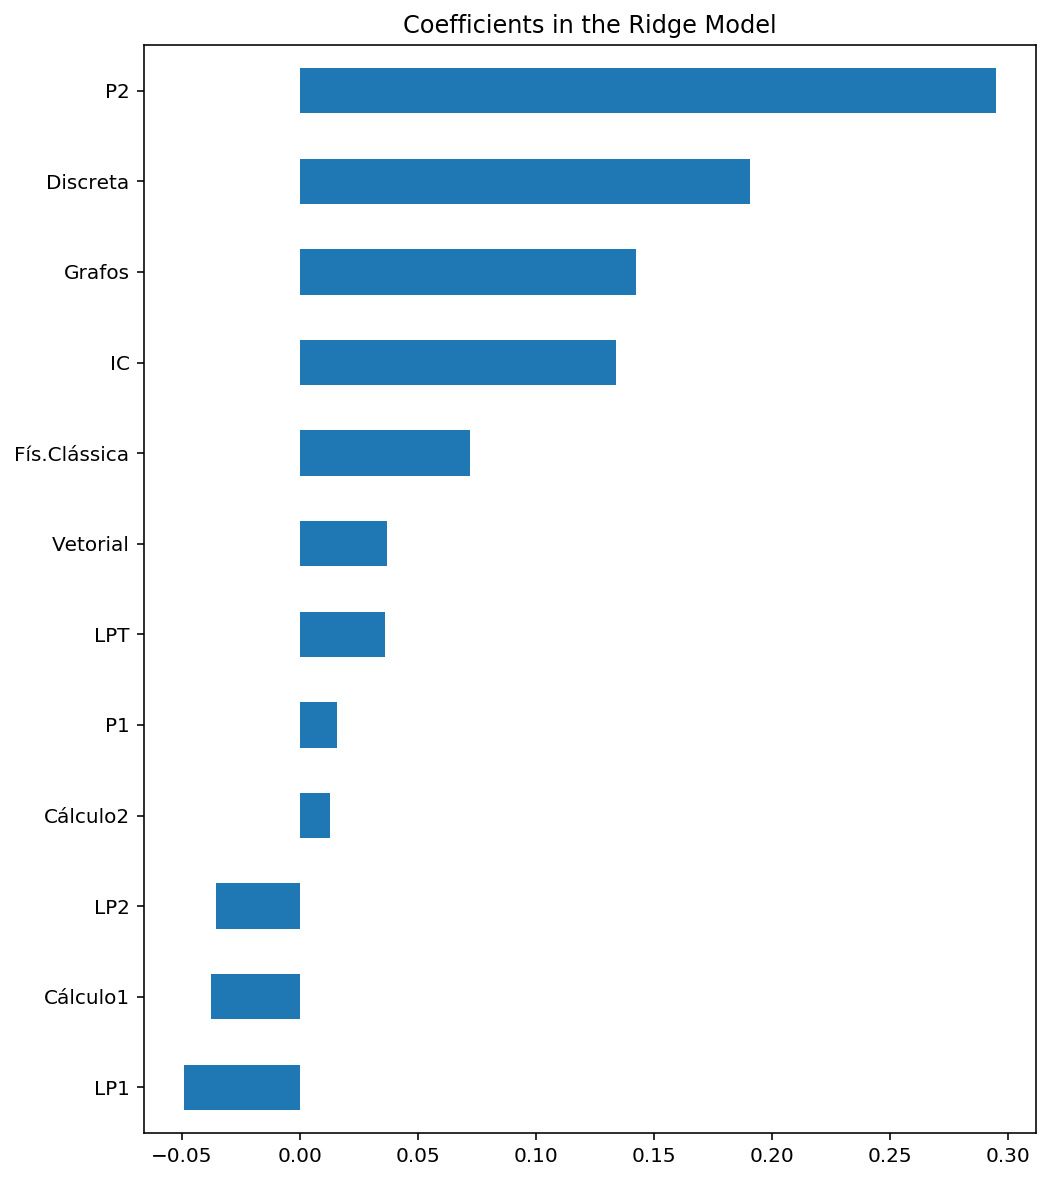

In [356]:
coef =  pd.Series(model_ridge.coef_, index = X_train.columns)

imp_coef = coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

# ============================================================

## Lasso

Para a regressão do tipo Lasso o RMSE é quase idêntico ao Ridge. O mesmo vale dizer para o peso das variáveis, que estão organizadas inclusive da mesma forma. Aqui o <b>alpha = 0</b> também.

In [357]:
model_lasso = Lasso(alpha = 0).fit(X_train, y)

pred = model_lasso.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))

RMSE: 0.5918653213911897


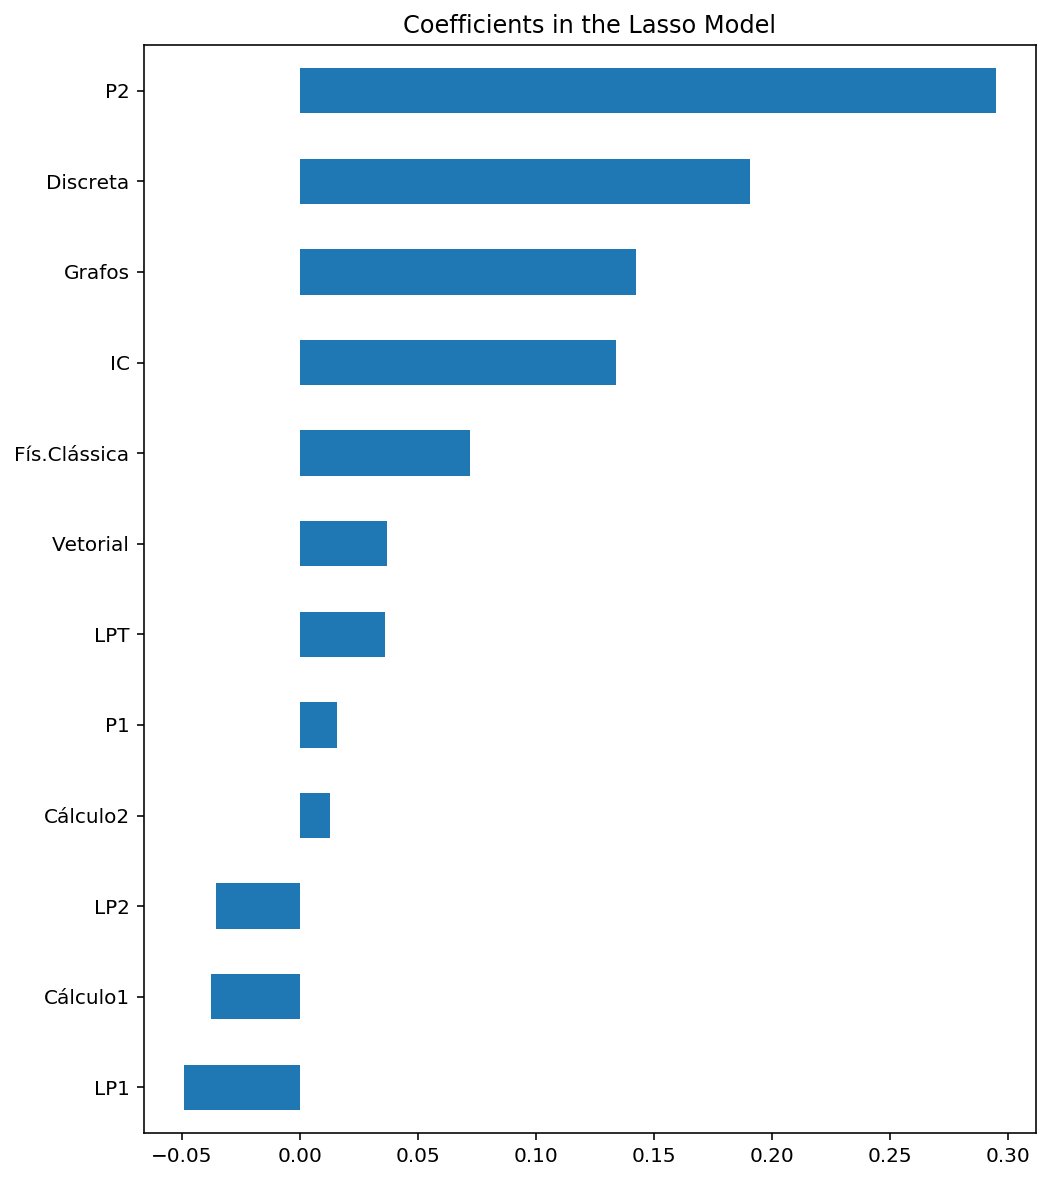

In [358]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = coef.sort_values() 

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# ============================================================

## K-nn 

Para o modelo de vizinhos e parâmetro utilizado foi <b>n_neighbors = 2</b>, pois é o mínimo que o modelo suporta. Podemos observar aqui que o RMSE foi ainda maior que para o Lasso e Ridge.

In [359]:
neigh = KNeighborsRegressor(n_neighbors=2).fit(X_train,y)
pred = neigh.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))


RMSE: 0.6188212314944543


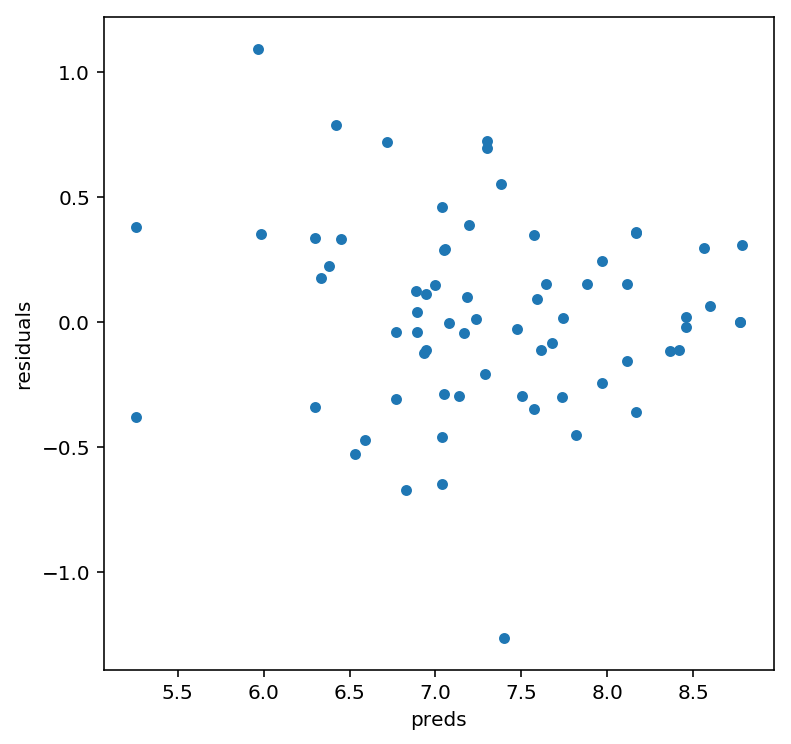

In [360]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":neigh.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# ============================================================

# Modelos tunados 

Nesta sessão os modelos foram analisados para obter os melhores <b>alphas</b>, utilizando regularização, para Lasso e Ridge, e no caso do K-nearest-Neighbors o melhor <b>N</b>.

Além dos parâmetros que foram modificados, duas variáveis foram criadas, sendo elas: <b>p1-lp1</b> e <b>p2-lp2</b>. O principal motivo da criação dessas variáveis é que as notas dessas disciplinas são dependentes e talvez se analisadas em separado não tenham tanto peso para predição do CRA como quando analisadas em conjunto.

In [361]:
all_data["p2-lp2"] = all_data["P2"] * 0.7 + all_data["LP2"] * 0.3
all_data["p1-lp1"] = all_data["P1"] * 0.7 + all_data["LP1"] * 0.3

del all_data["LP1"]
del all_data["P1"]
del all_data["LP2"]
del all_data["P2"]



train = all_data[:-20]
test = all_data[-20:]

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

del X_train["cra"]
del X_test["cra"]

y = train.cra
y_test = test.cra


### Lasso

Como podemos ver no gráfico abaixo, o menor RMSE é quando o <b>alpha = 0.06</b>, o que utilizaremos na construção do modelo agora.

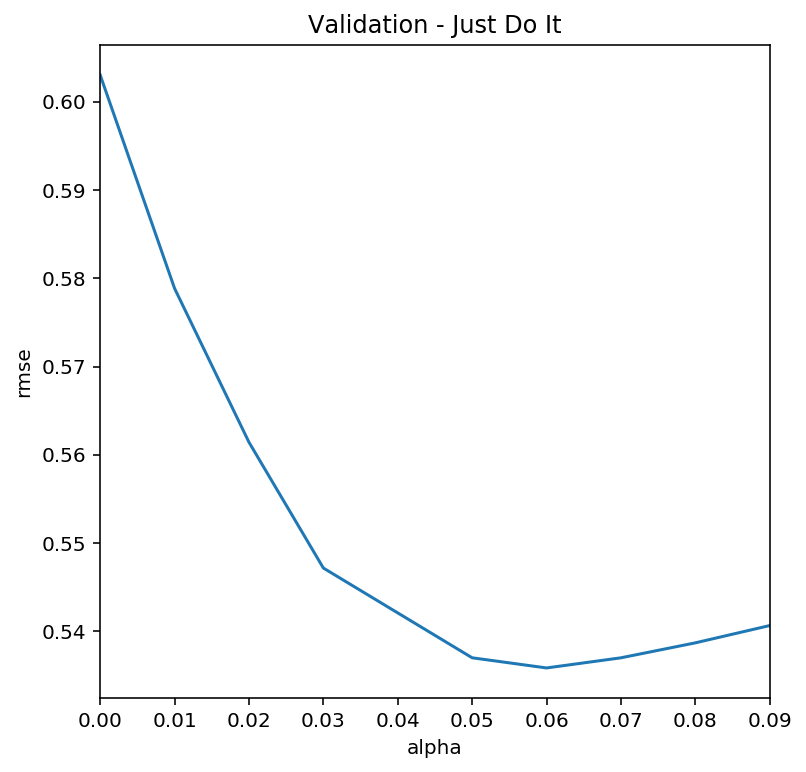

In [362]:
alphas = [0, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09]

cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [363]:
model_lasso = Lasso(alpha = 0.06).fit(X_train, y)

In [364]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print\
 ("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + \
  str(sum(coef == 0)) + " variables")
print(coef)    

Lasso picked 6 variables and eliminated the other 4 variables
Vetorial        0.058250
LPT             0.000000
IC              0.057389
Cálculo2        0.000000
Discreta        0.183330
Grafos          0.168212
Fís.Clássica    0.019301
Cálculo1       -0.000000
p2-lp2          0.205361
p1-lp1          0.000000
dtype: float64


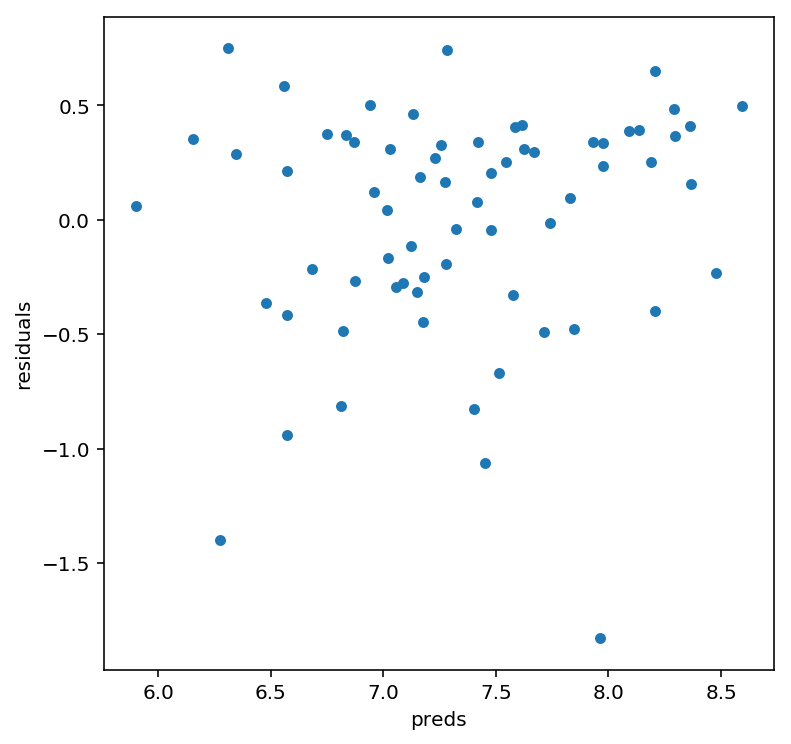

In [365]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

<p></p>

A diferença do RMSE é considerável, antes de tunarmos nossos parâmetros o <b>rmse = 0.592</b> e agora <b>rmse = 0.535</b>

In [366]:
rmse_cv(model_lasso).mean()

0.53585201252106707

In [367]:
pred = model_lasso.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))

RMSE: 0.5370762250162978


<p></p>

Já para os coeficientes podemos ver que 4 deles foram zerados mas os que haviam sido considerados de maior peso aqui também aparecem. Podemos notar também que a variável que foi criada (<b>p2-lp2</b>) está com o maior peso na predição.

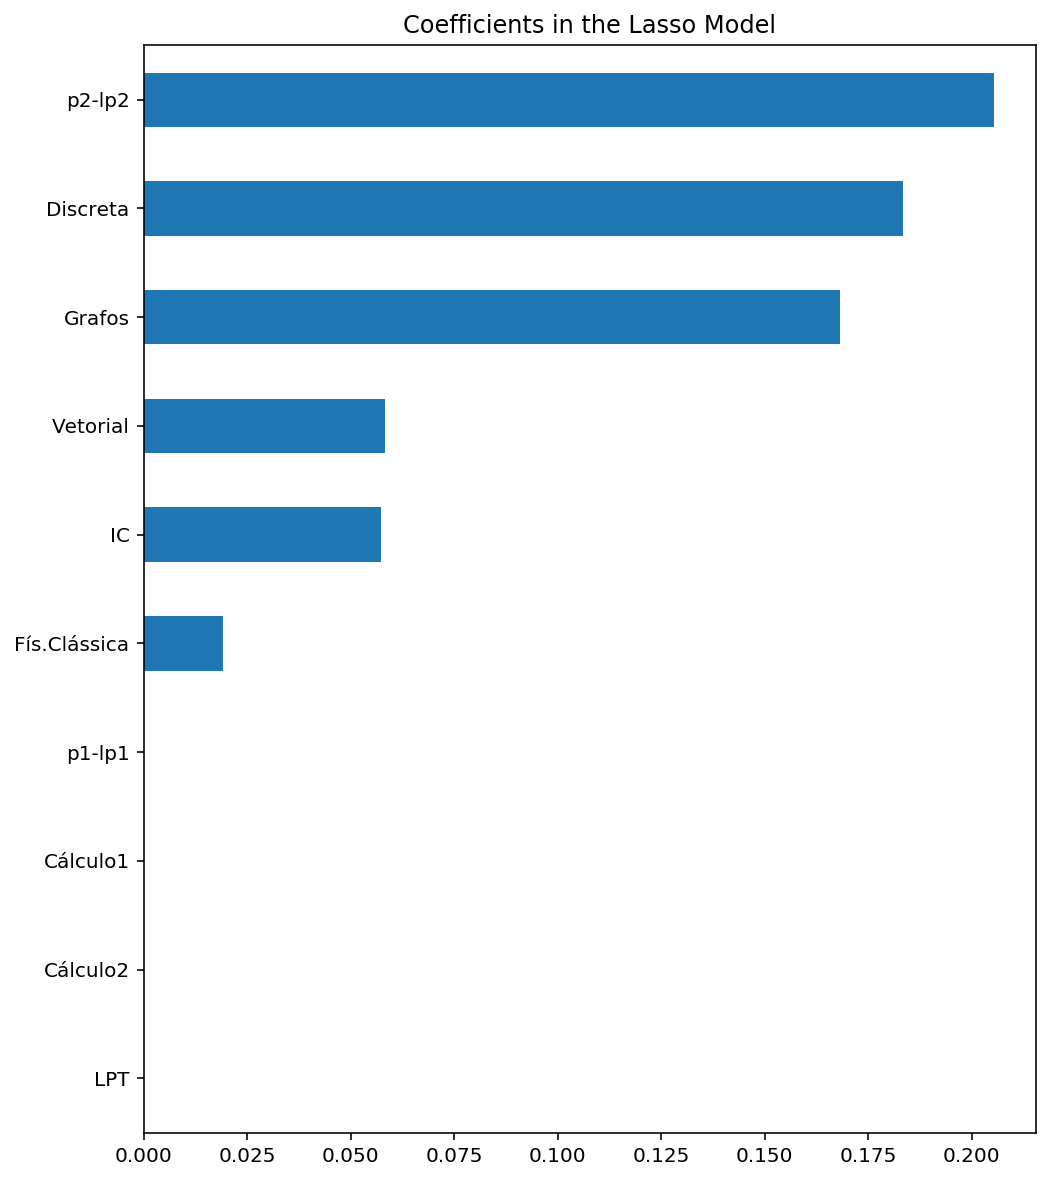

In [368]:
imp_coef = coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Ridge

A mesma análise dos alphas foi feita para Ridge e podemos ver que o RMSE é o mais baixo quando <b>alpha = 50</b>.

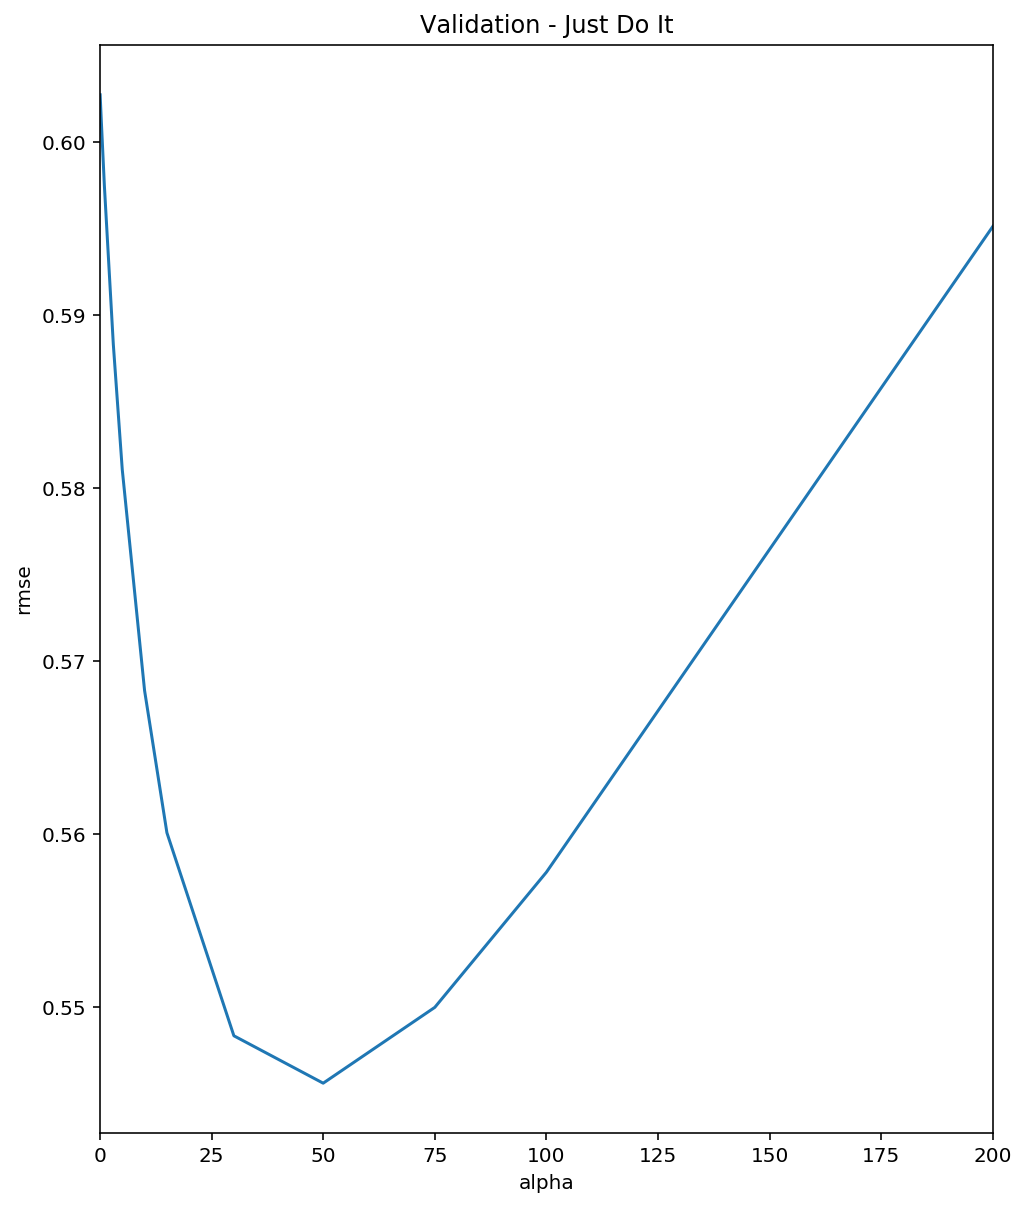

In [369]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100,200]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

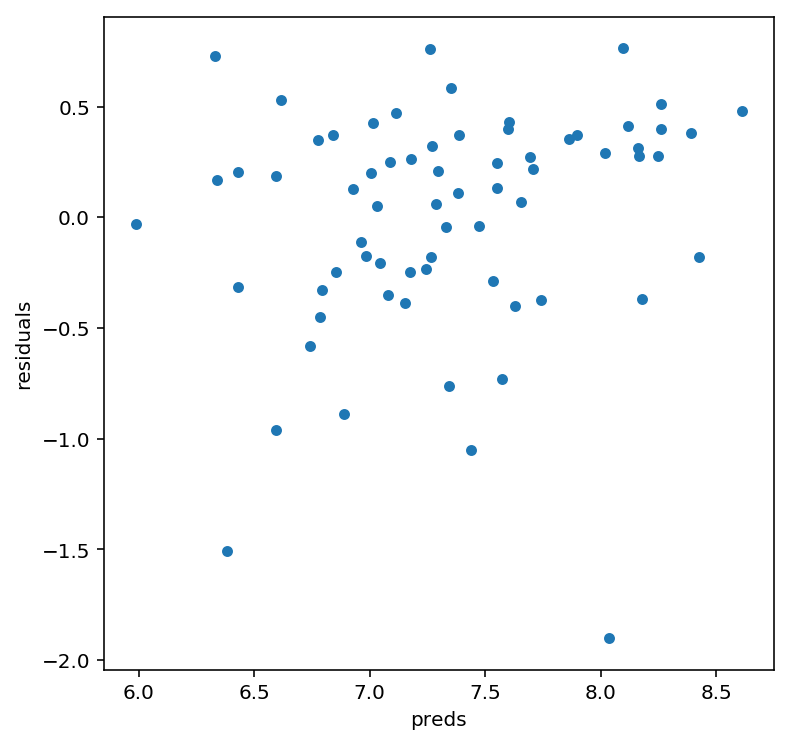

In [370]:
model_ridge = Ridge(alpha = 50).fit(X_train,y)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

<p></p>

Do mesmo modo que no Lasso, o RMSE foi diminuido graças as mudanças nos parâmetros e a criação das novas variáveis.
Antes o <b>rmse = 0.592</b> agora <b>rmse = [0.545,0.551]</b>.

In [371]:
cv_ridge.min()

0.54562538623968204

In [372]:
pred = model_ridge.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))

RMSE: 0.5514145933132086


<p></p>

O modelo Ridge não tenta zerar as features como Lasso faz, entretanto ele aproxima o máximo de zero, como podemos ver foi o que aconteceu com <b>Cálculo1</b>. Já para as de maior peso para predição de CRA podemos ver que nesse caso <b>Discreta</b> ficou em primeiro lugar, porém, novamente <b>p2-lp2</b> aparece entre as de maior peso.

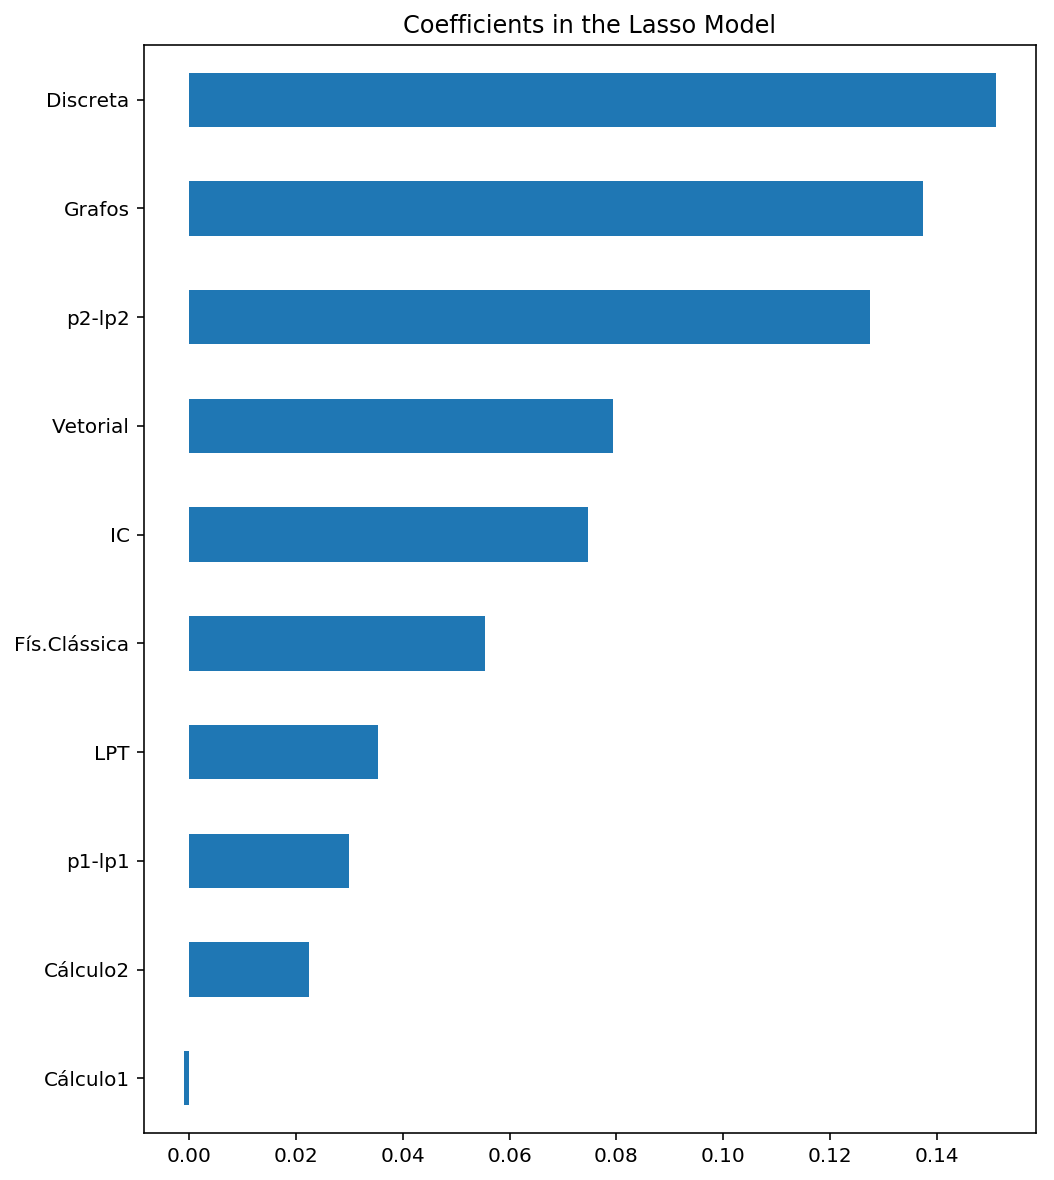

In [373]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)

imp_coef = coef.sort_values()

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### K-nn

Por último nesse modelo vemos que o menor RMSE é quando <b>N = 12</b>.

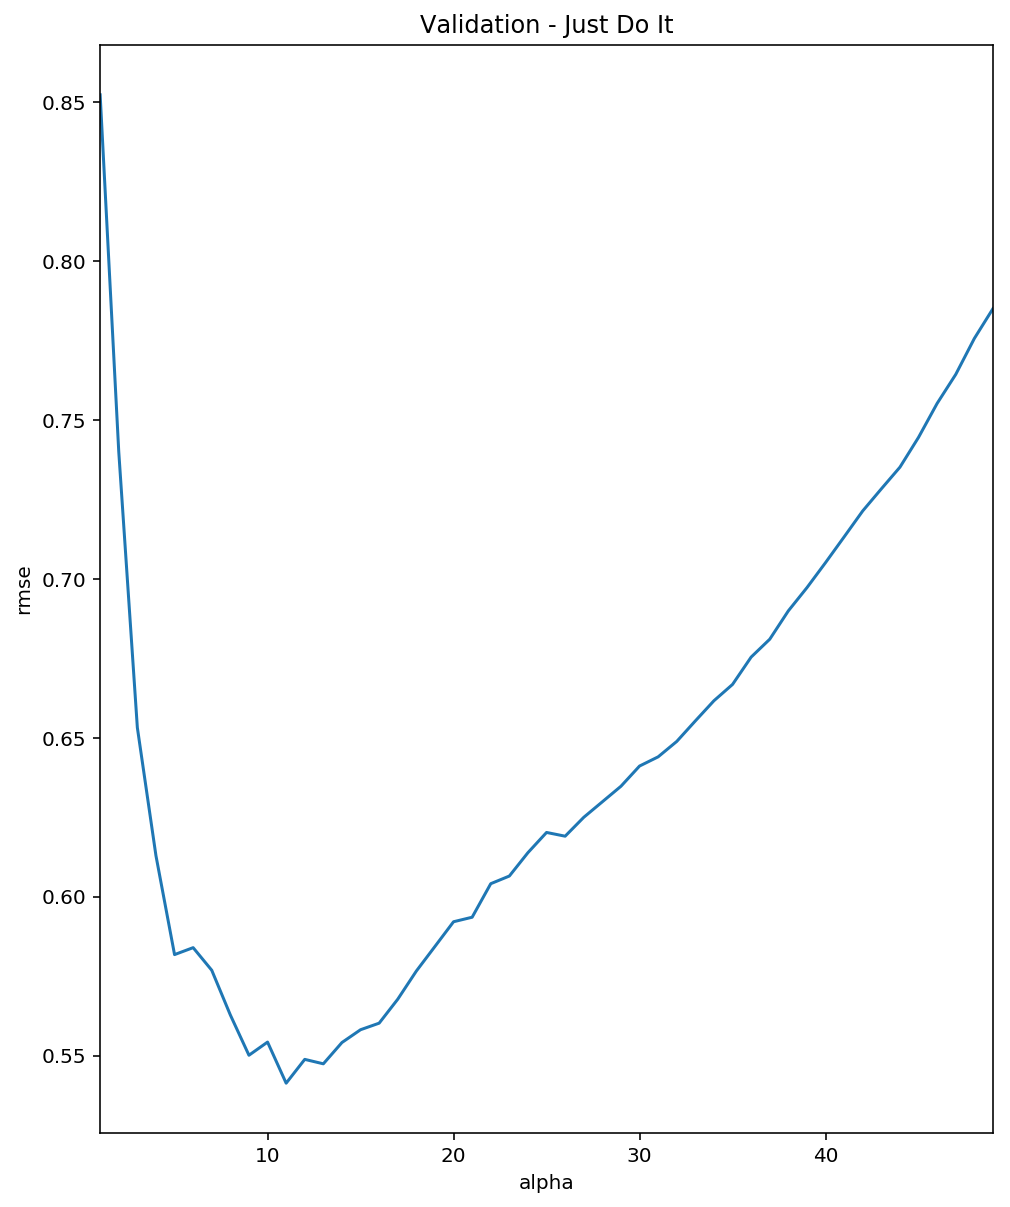

In [374]:
neighbors = [x for x in range(1, 50)]

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = nb)).mean() 
               for nb in neighbors]

cv_knn = pd.Series(cv_knn, index = neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

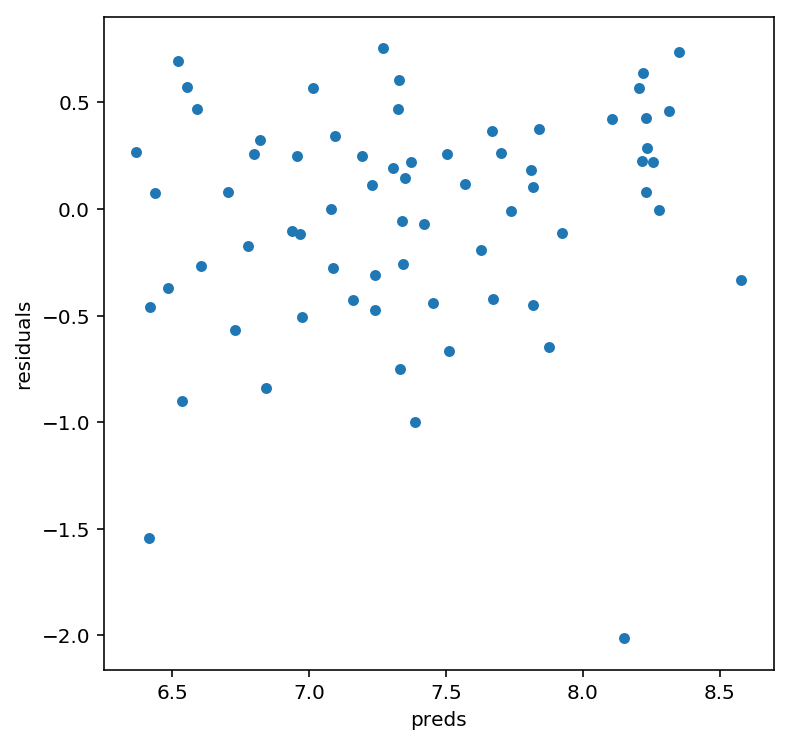

In [375]:
model_knn = KNeighborsRegressor(n_neighbors=12).fit(X_train,y)


matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_knn.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

E finalmente aqui podemos ver a diferença do RMSE para o modelo k-nn com o parâmetro alterado. Antes o <b>rmse = 0.618</b> e agora <b>rmse = 0.541</b>.

In [376]:
cv_knn.min()

0.54141453650288685

In [377]:
pred = model_knn.predict(X_test)
print("RMSE: {0}".format(rmse(y_test,pred)))

RMSE: 0.5476886393739325
